## ДЗ_1. Временные ряды.

### Анализ времянных рядов 
При помощи:
* преобразования Бокса-Кокса
* дифференцирования
* формулы для того что бы убрать влияние сезонности

In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
# функция для проведения теста Dickey-Fuller и вывода результатов.

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
# функция вывода графиков коррелограмм 

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Загружаем данные из файов

In [4]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [5]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

#### Отображение графика

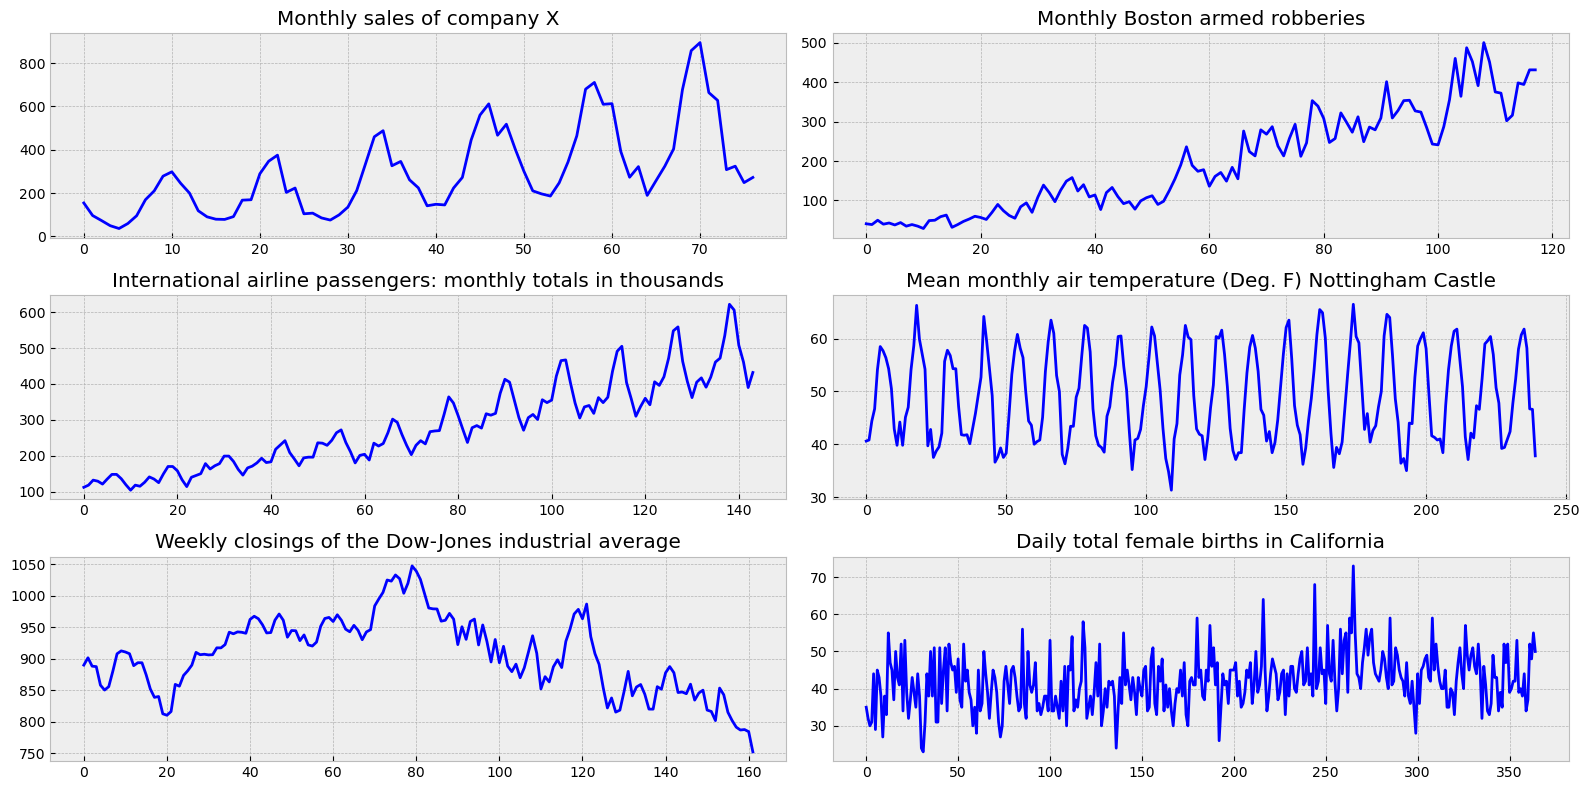

In [6]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

#### Сначала определим те ряды, которые изначально могут быть стационарными

In [7]:
def adf_test(timeseries):
    '''Функция выводи p-value, для определения временных рядов, которые стационарные используя тест Дики-Фуллера
    '''
    dftest = adfuller(timeseries, autolag="AIC")
    p_value = dftest[1] if dftest[1] is not None else 1.0
    return p_value

In [8]:
p_values = {name: adf_test(series) for name, series in all_series.items()}

stationary_series = {name: all_series[name] for name, p_value in p_values.items() if p_value < 0.05}
non_stationary_series = {name: all_series[name] for name, p_value in p_values.items() if p_value >= 0.05}

count_sr = 0
count_nsr = 0

print(f'\033[1mСтационарные ряды:\033[0m')
for name in stationary_series.keys():
    count_sr += 1
    print(name)
    
print(f'\n\033[1mНе стационарные ряды:\033[0m')
for name in non_stationary_series.keys():
    count_nsr += 1
    print(name)

print(f'\nИз полученных выше данных, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда для {count_sr} рядов!')

Стационарные ряды:
Mean monthly air temperature (Deg. F) Nottingham Castle
Daily total female births in California

Не стационарные ряды:
Monthly sales of company X
Monthly Boston armed robberies
International airline passengers: monthly totals in thousands
Weekly closings of the Dow-Jones industrial average

Из полученных выше данных, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда для 2 рядов!


#### Проверим нашу теорию графиками коррелограмм

In [9]:
# series = mean_monthly_temp["Deg"]
series = female_births["Count"] 

In [10]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -4.353173
p-value                          0.000359
#Lags Used                       7.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64


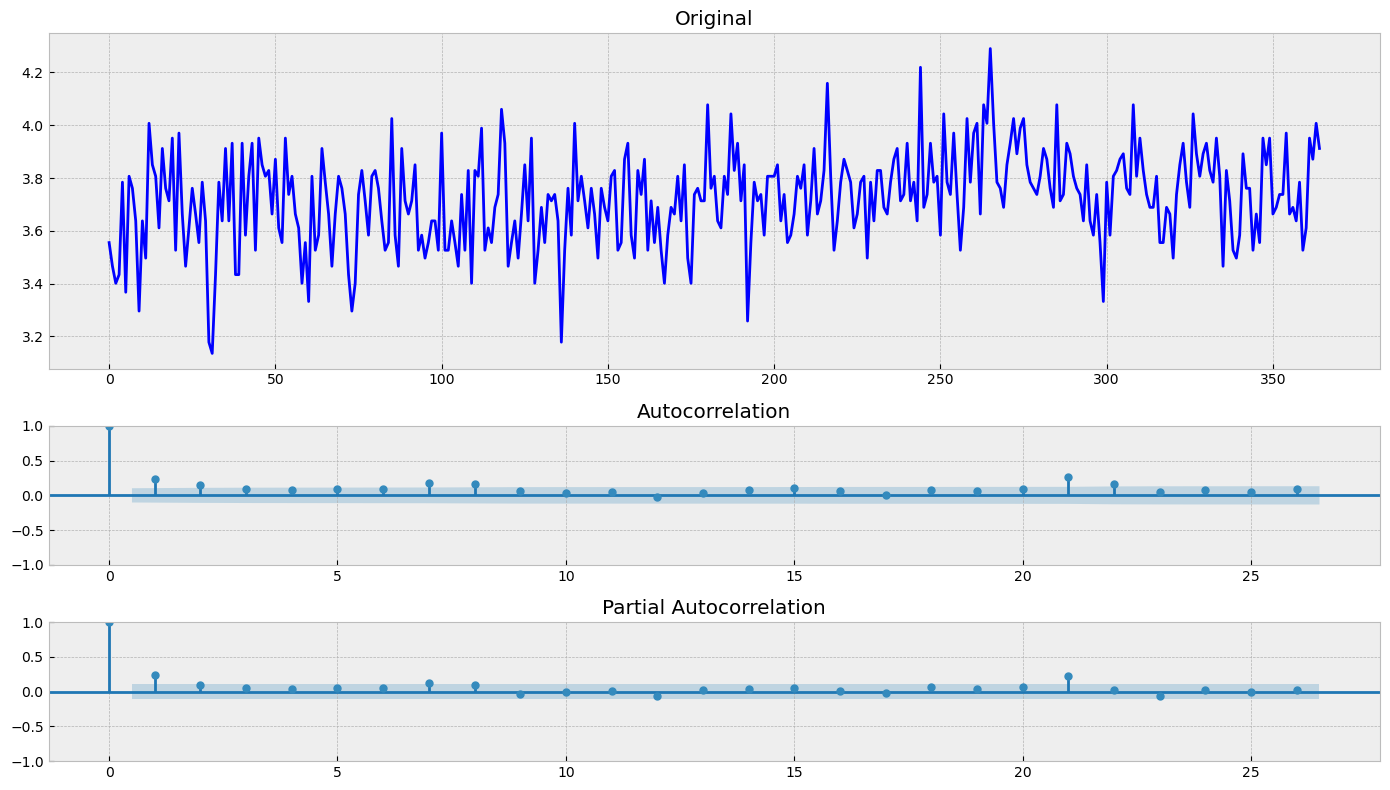

In [11]:
tsplot(series)

> Графики коррелограмм отвергают гипотезу о нестационарности ряда!

> Далее будем считать что тест пройден для двух рядов, и будем смотреть на оставшиеся 4.

### Далее работаем с 4-мя оставшимися рядами

In [12]:
for i in non_stationary_series: # выводим ряды, с которыми будем работать далее
    print(i)

Monthly sales of company X
Monthly Boston armed robberies
International airline passengers: monthly totals in thousands
Weekly closings of the Dow-Jones industrial average


### Ищем сезонность

In [13]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

Monthly sales of company X
Monthly Boston armed robberies
International airline passengers: monthly totals in thousands
Weekly closings of the Dow-Jones industrial average


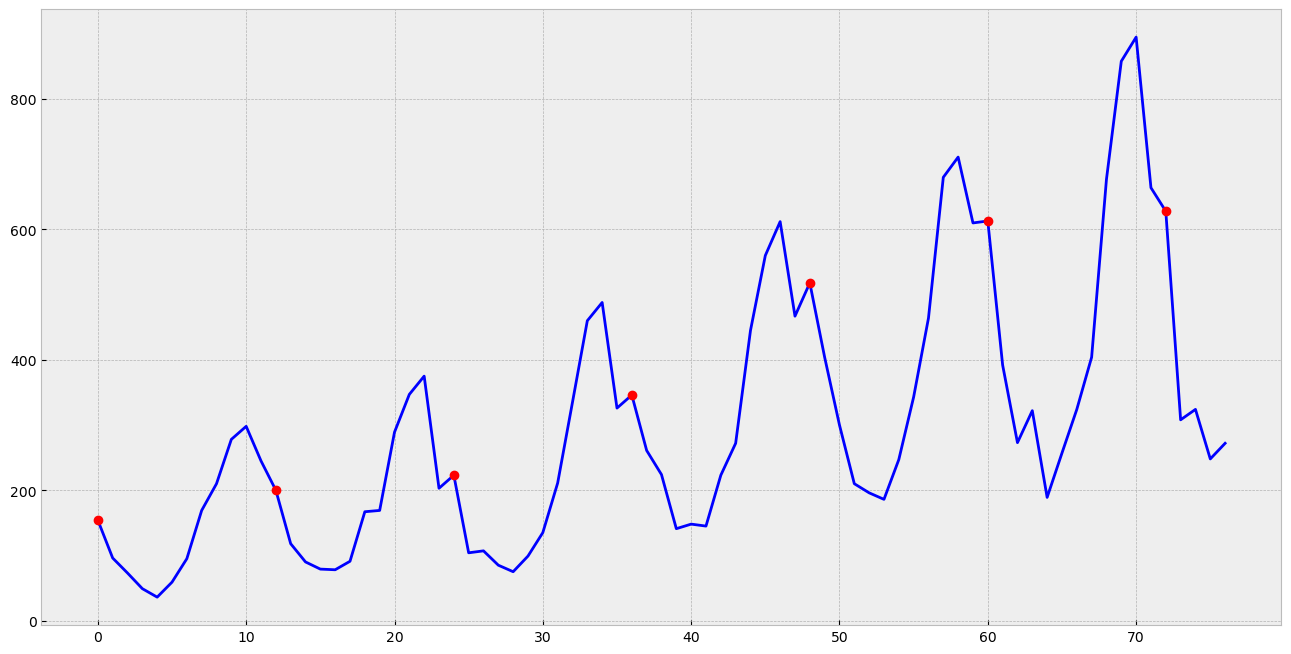

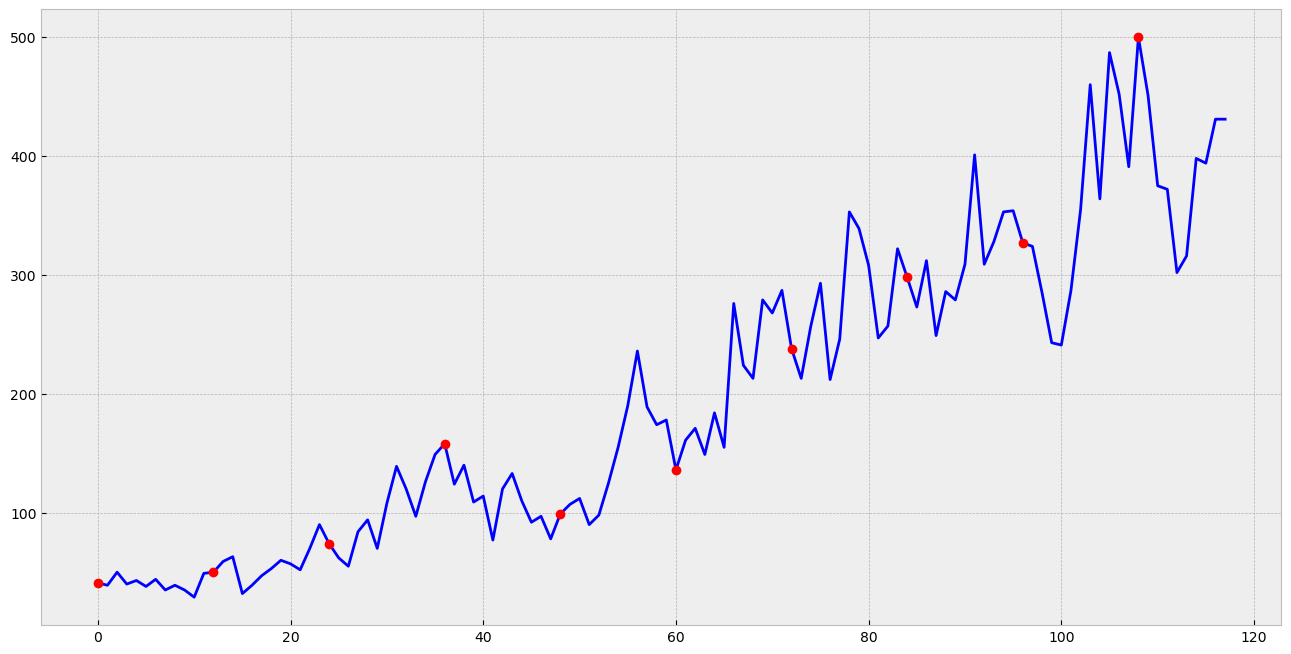

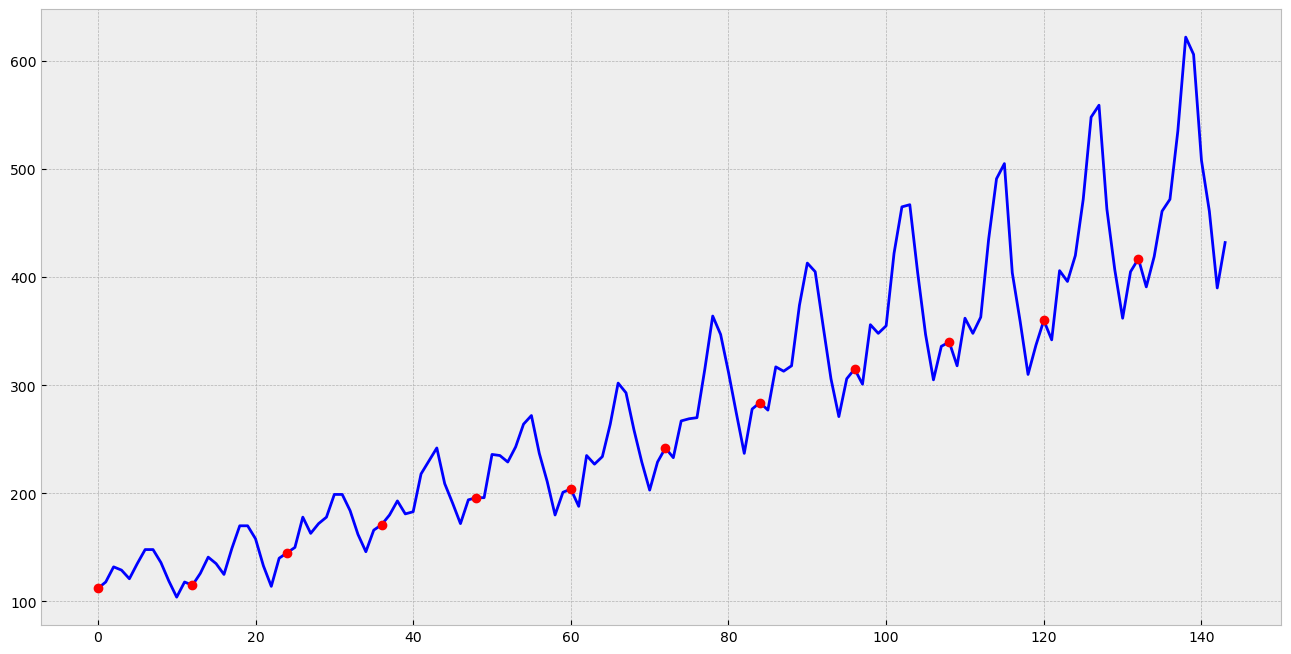

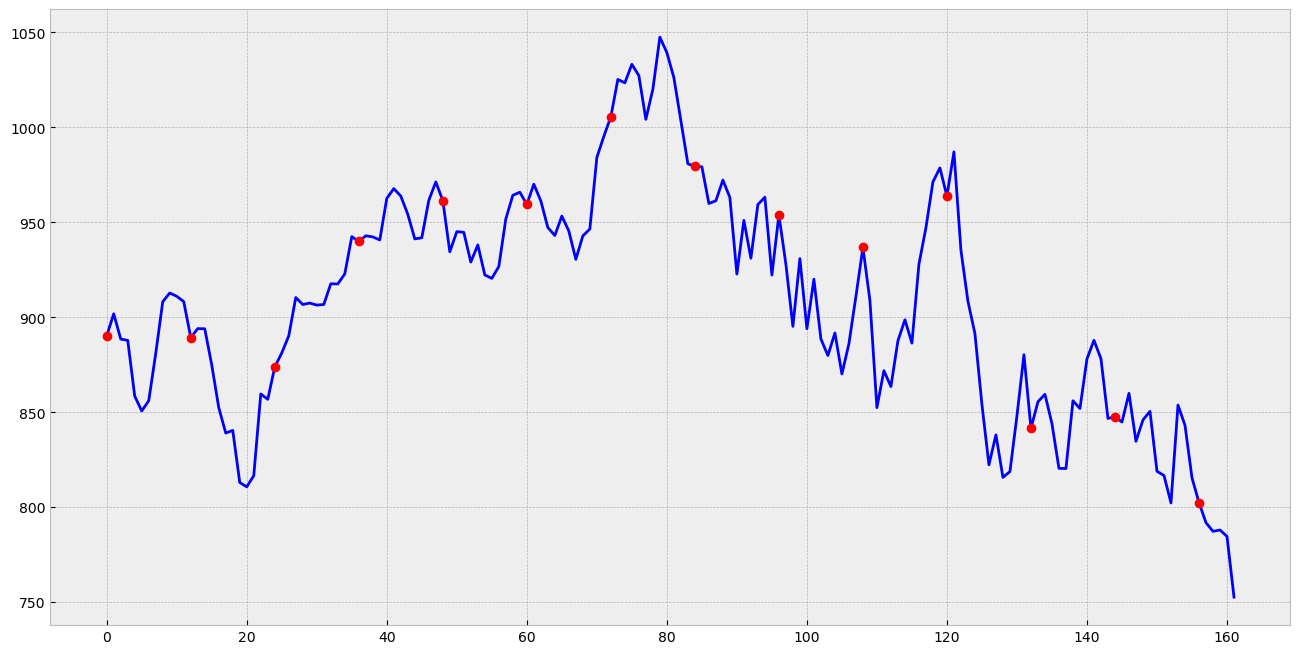

In [14]:
for i in non_stationary_series:
    print(i)
    plot_ts_and_points(all_series[i], 0, 12)

> **очень красиво получилось и сразу видно где есть сезонность. (1 и 3)**

### Временной ряд для анализа: Monthly sales of company X

Анализиурем и убираем сезонность и тренд при наличии используем уже полученные данные по сезонности выше.

***По графику выше, мы определили сезонности.*** проверим нашу гипотезу

In [15]:
#  Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

series_1 = boxcox(all_series["Monthly sales of company X"], 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


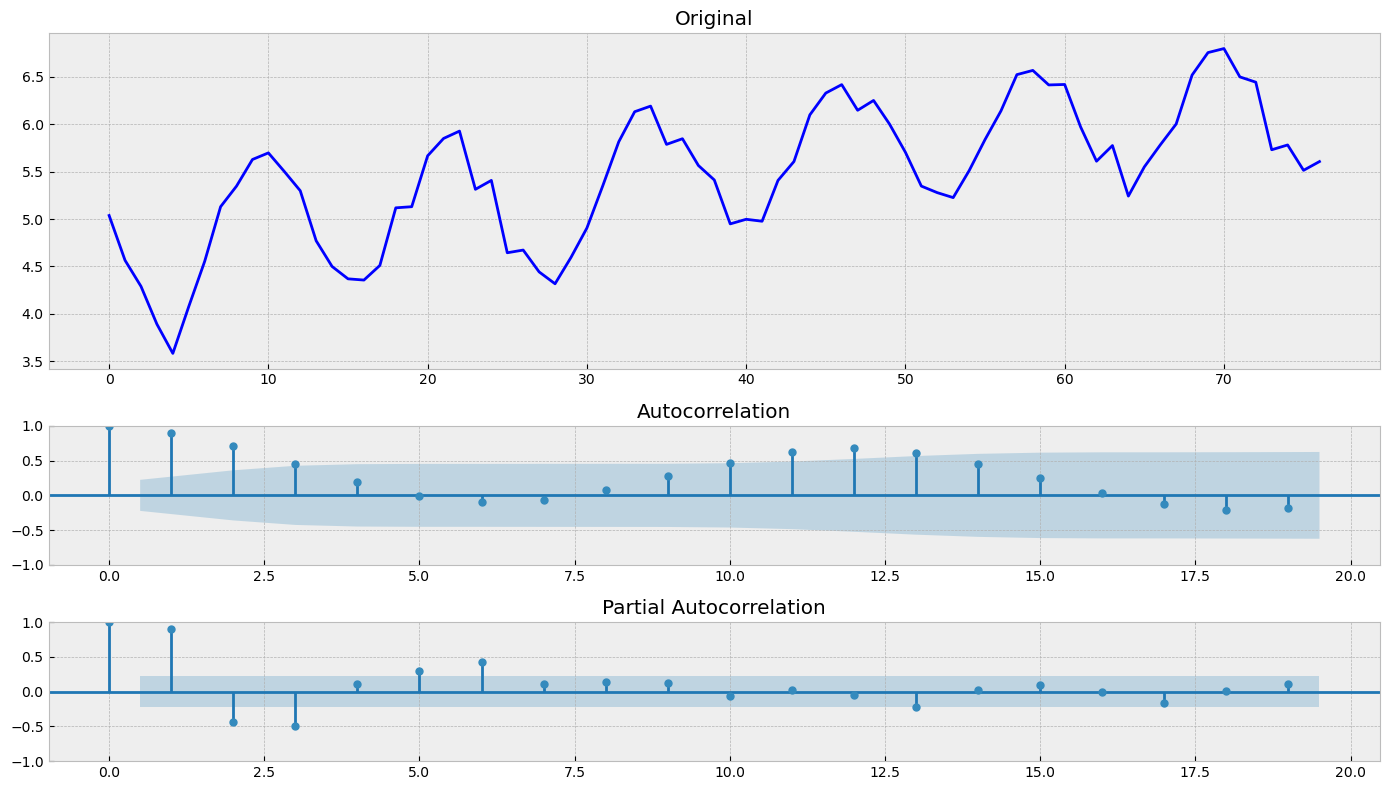

In [16]:
tsplot(series_1)

Видим что остается тренд и сезонность. **Попытаемся убрать сезонность.**

In [17]:
series_1 = series_1[12:] - series_1[:-12]

Results of Dickey-Fuller Test:
Test Statistic                 -2.385128
p-value                         0.145978
#Lags Used                     11.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


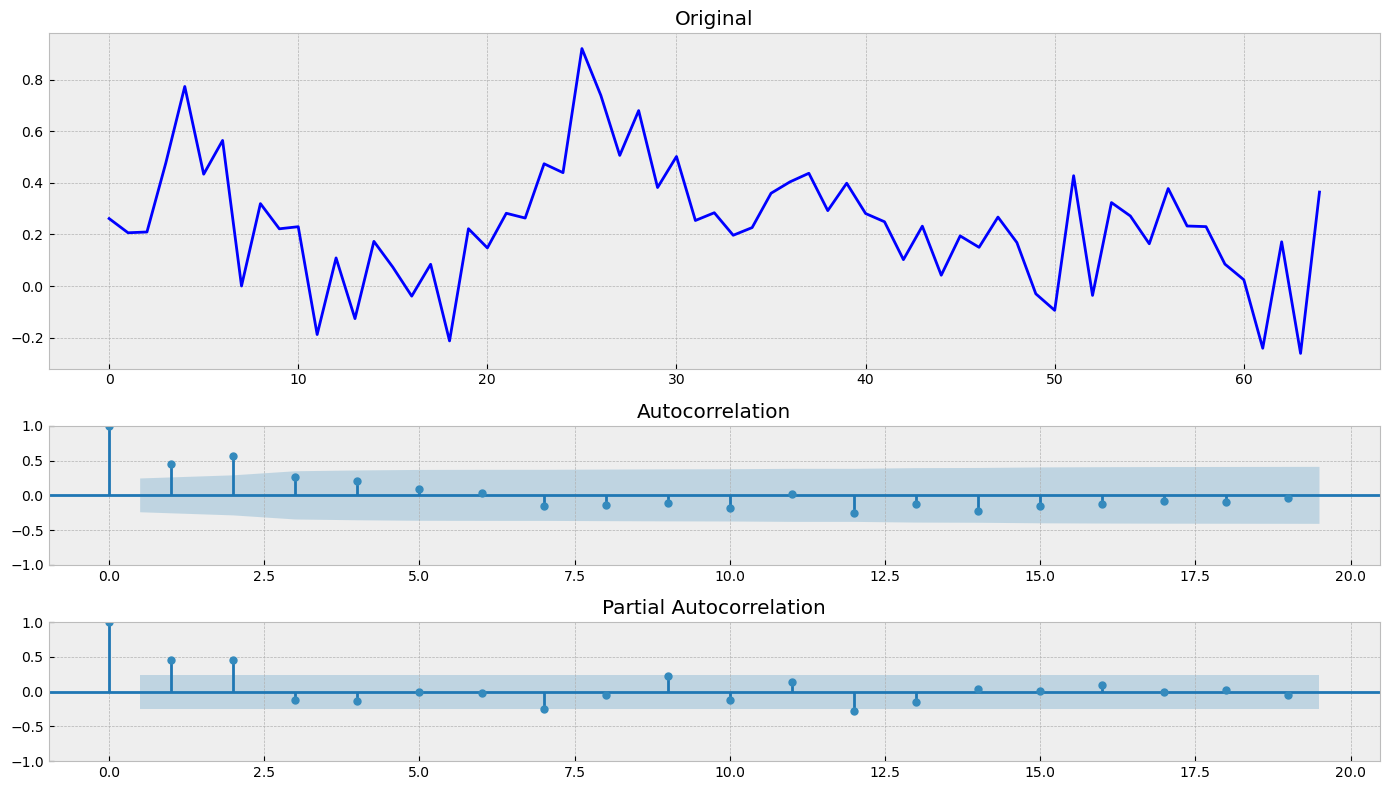

In [18]:
tsplot(series_1)

Сезонность убрали, но пока тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда, решил использовать дифференцирование.

In [19]:
series_1 = series_1[1:] - series_1[:-1]

Results of Dickey-Fuller Test:
Test Statistic                 -2.316045
p-value                         0.166845
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


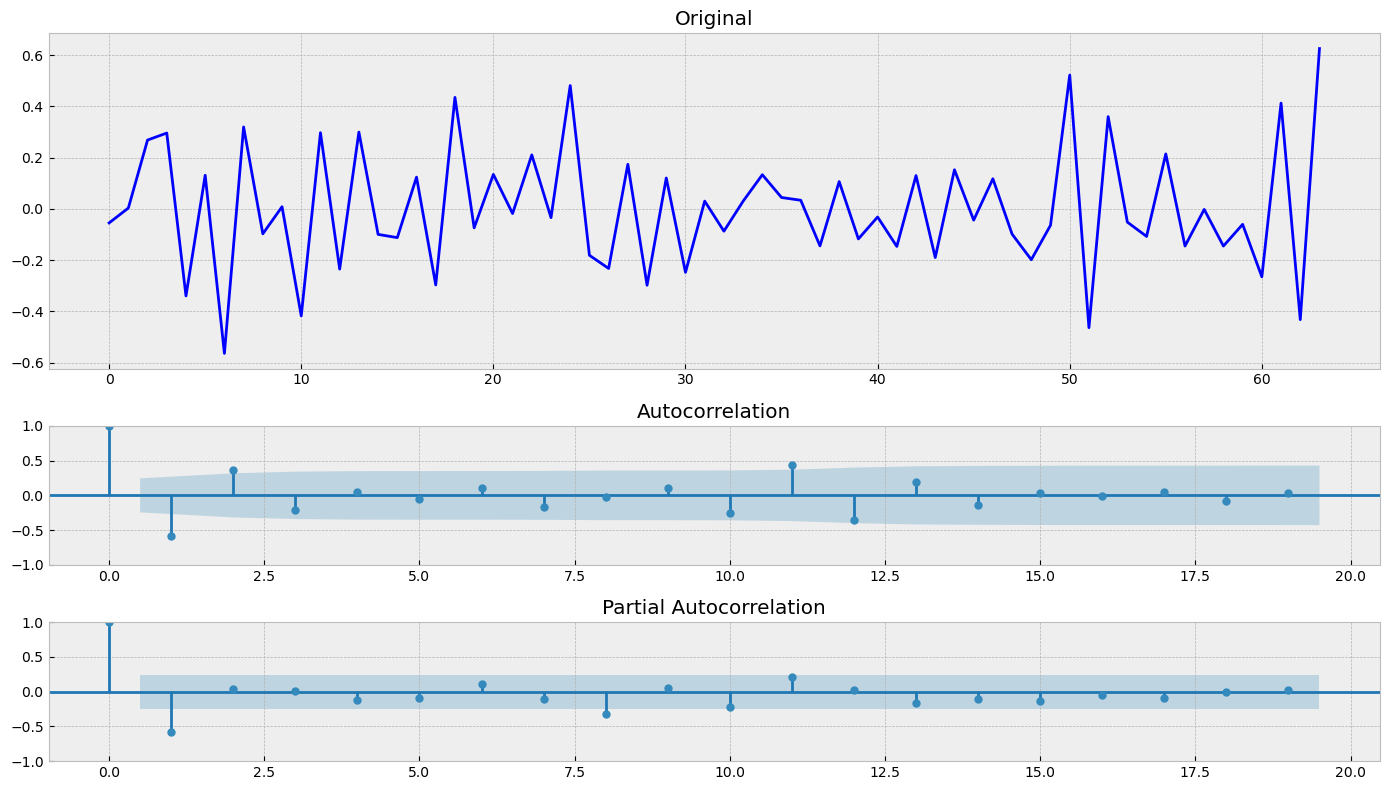

In [20]:
tsplot(series_1)

> Стало значительно лучше. Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!

### Временной ряд для анализа: Monthly Boston armed robberies

Анализиурем и убираем сезонность и тренд при наличии используем уже полученные данные по сезонности выше.

****По графику выше, мы определили отсутствие сезонности.*** проверим нашу гипотезу

In [21]:
#  Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

series_2  = boxcox(all_series["Monthly Boston armed robberies"], 0)

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


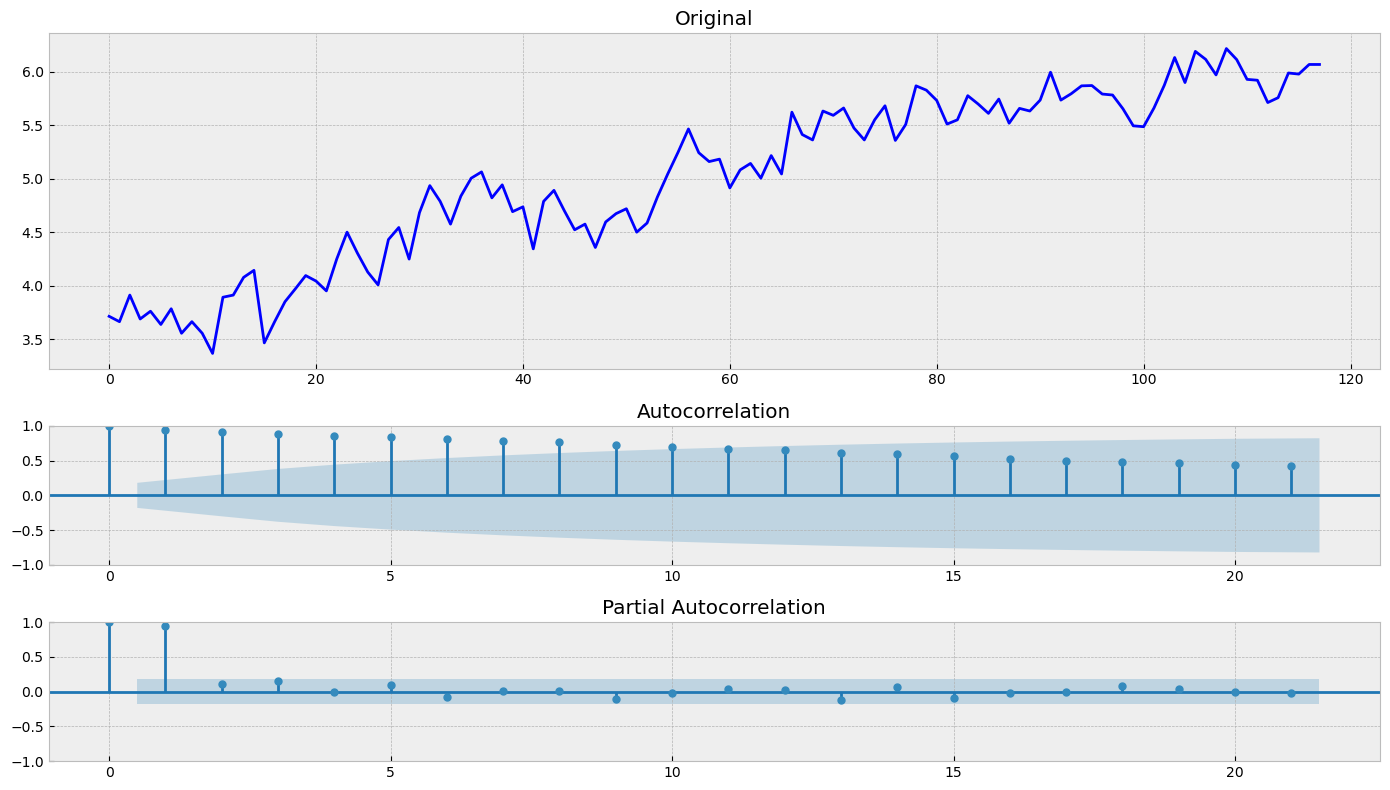

In [22]:
tsplot(series_2)

По графикам видем наличия тренда и предположительно отсутствие сезонности

Убераю его дифференцированием.

In [23]:
series_2 = series_2[1:] - series_2[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


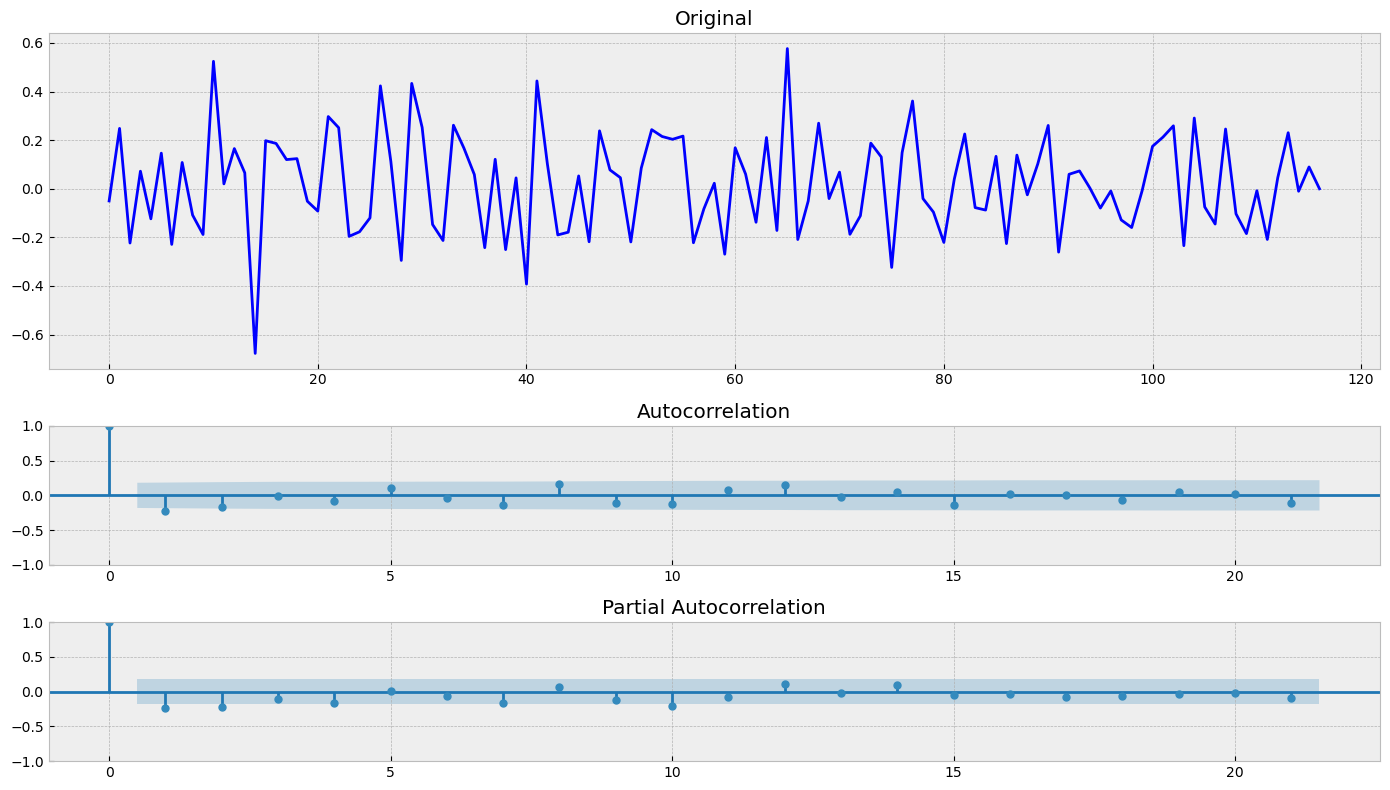

In [24]:
tsplot(series_2)

> Дифференцирование помогло. Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!

### Временной ряд для анализа: International airline passengers: monthly totals in thousands

Анализиурем и убираем сезонность и тренд при наличии используем уже полученные данные по сезонности выше.

***По графику выше, мы определили сезонность.*** проверим нашу гипотезу

In [25]:
#  Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

series_3  = boxcox(all_series["International airline passengers: monthly totals in thousands"], 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


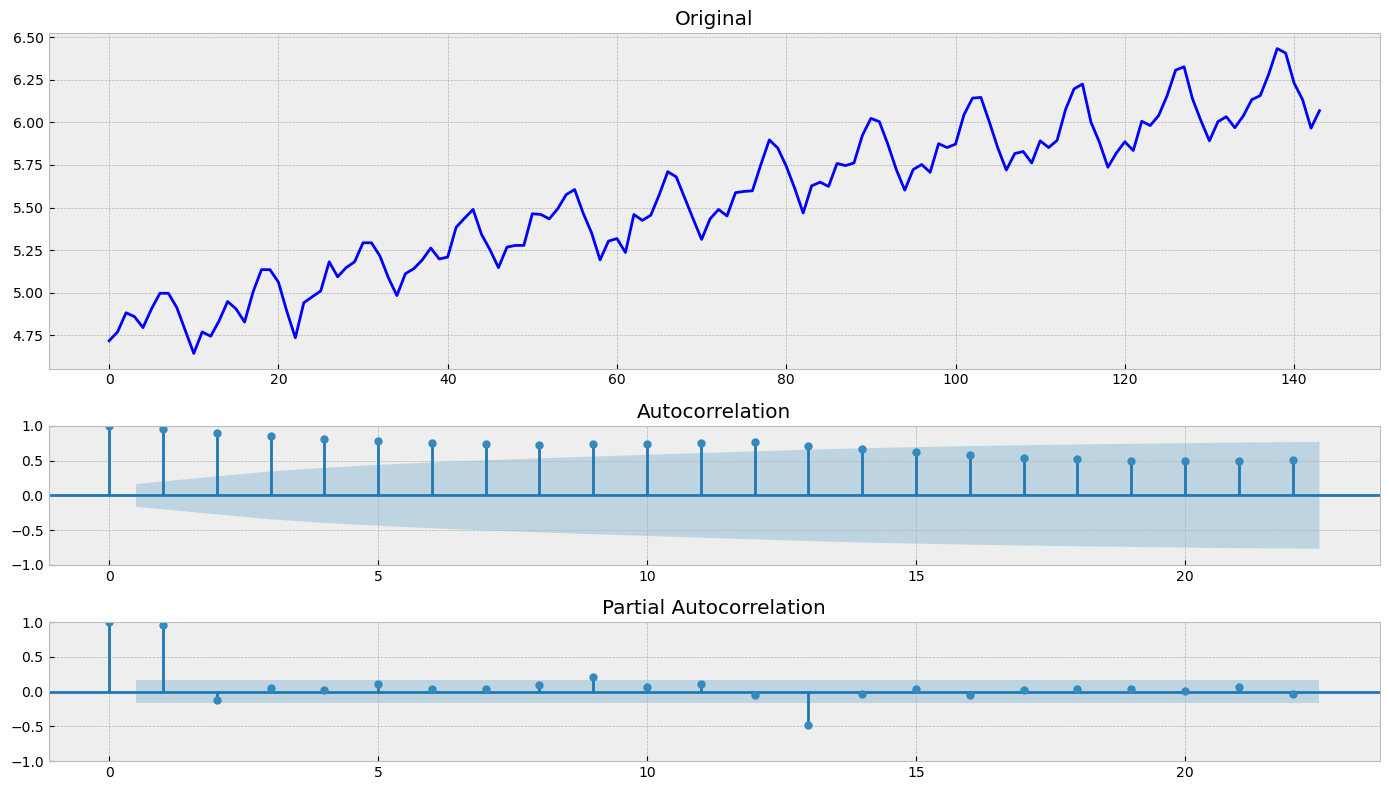

In [26]:
tsplot(series_3)

> Тест Дики-Фуллера и графики коррелограмм мы видим наличие сезонности и тренда!

Уберем его дифференцированием.

In [27]:
series_3 = series_3[1:] - series_3[:-1]

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


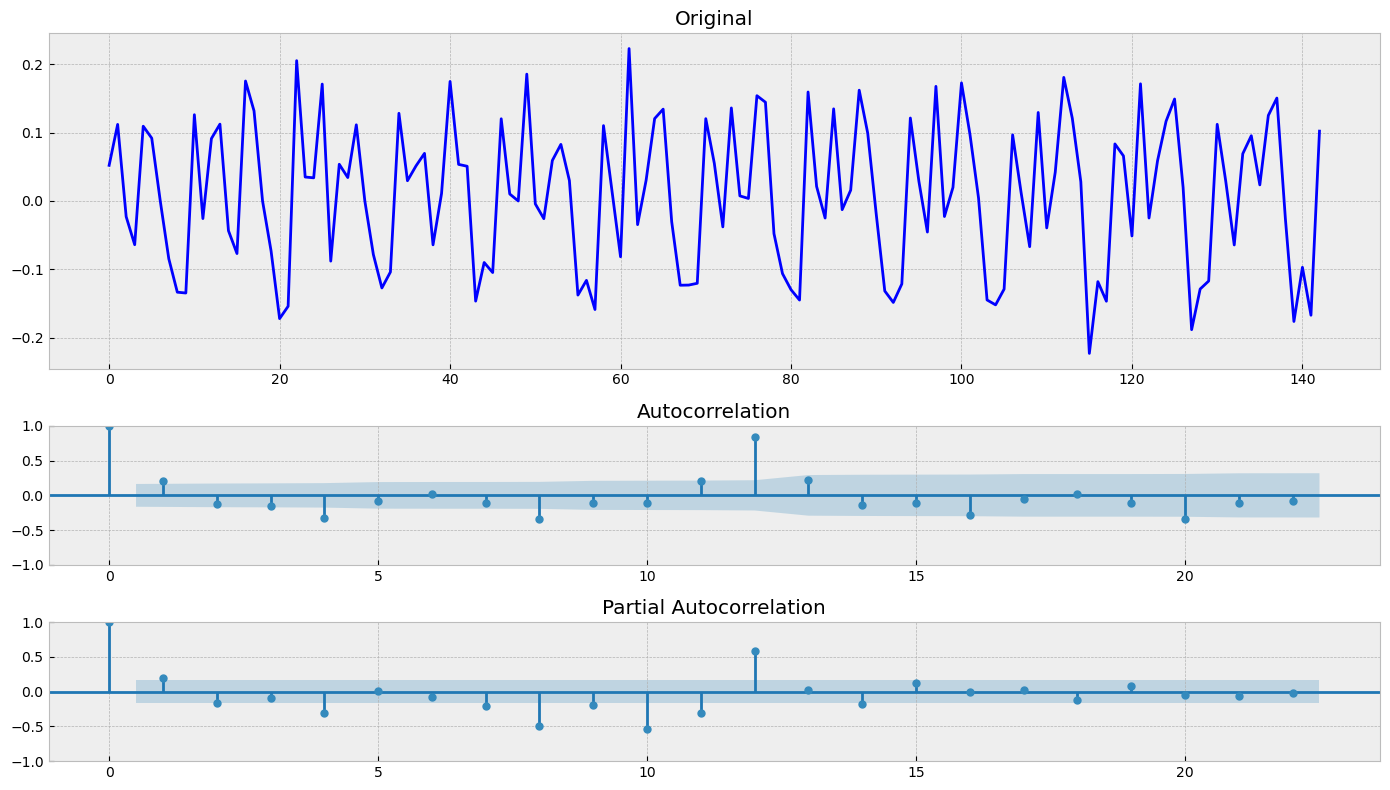

In [28]:
tsplot(series_3)

> Стало еще лучше, но по графику коррелограммы видно сильное влияние сезонности. Уберем ее

In [29]:
series_3 = series_3[12:] - series_3[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


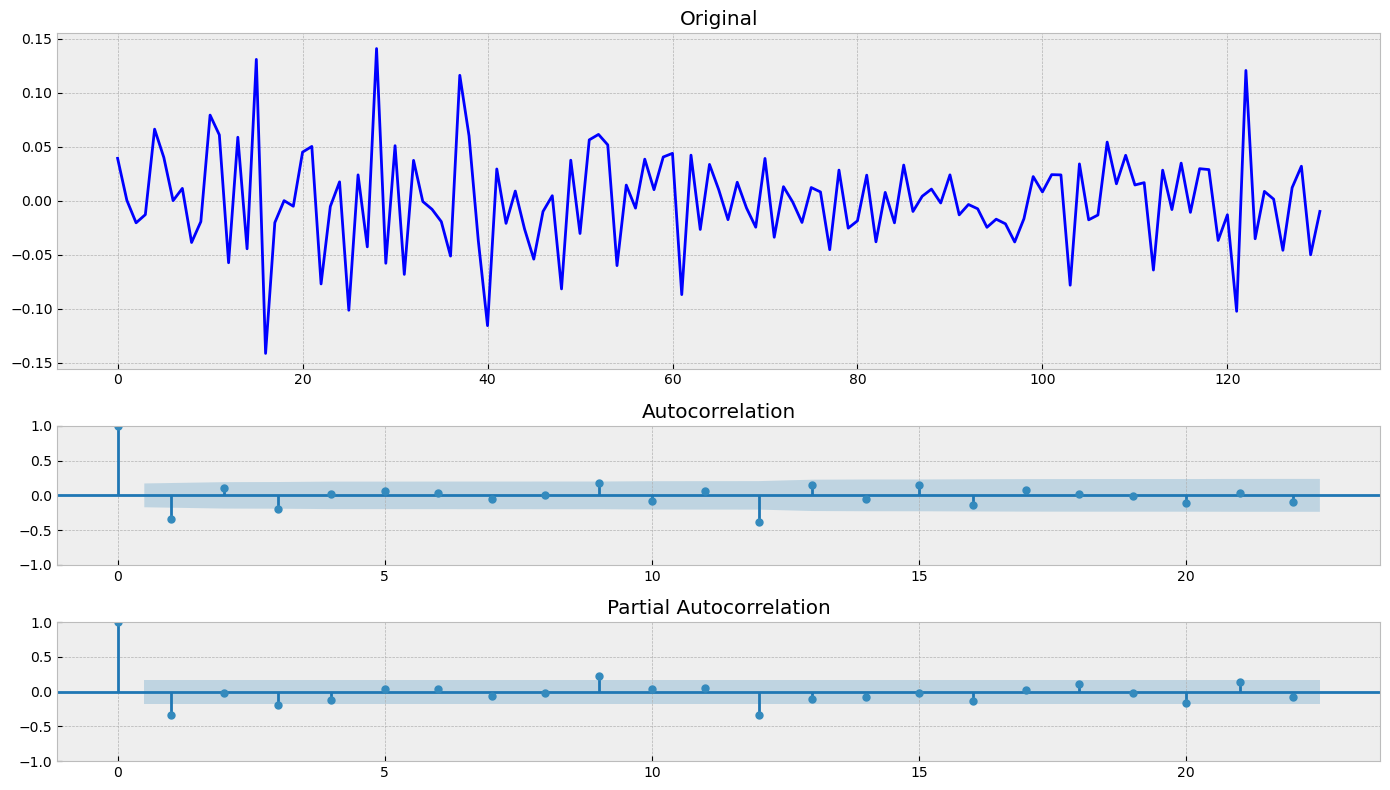

In [30]:
tsplot(series_3)

> **Итог**: убрав сезонность, тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!

### Временной ряд для анализа: International airline passengers: monthly totals in thousands

Анализиурем и убираем сезонность и тренд при наличии используем уже полученные данные по сезонности выше.

***По графику выше, мы определили отсутствие сезонности.*** проверим нашу гипотезу

In [31]:
#  Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

series_4  = boxcox(all_series["Weekly closings of the Dow-Jones industrial average"], 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


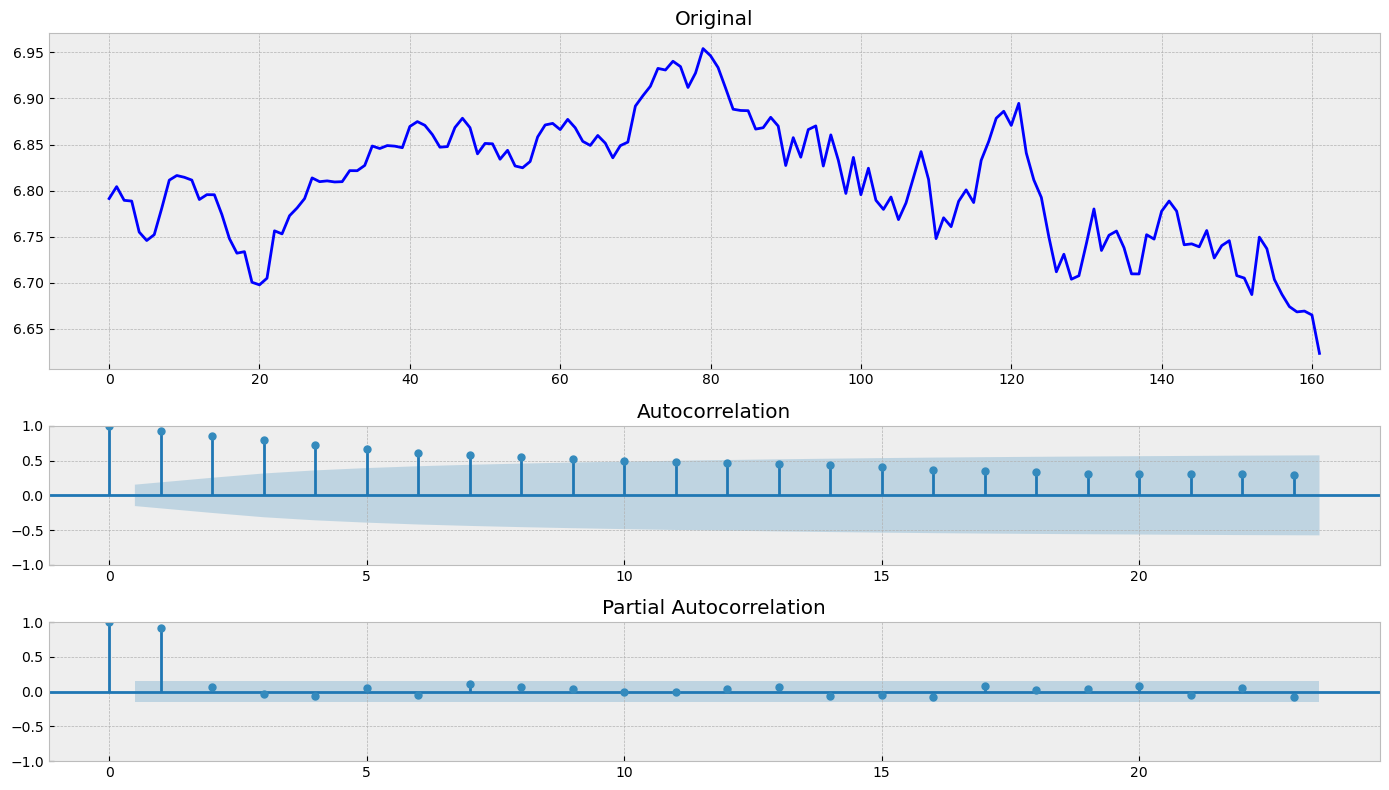

In [32]:
tsplot(series_4)

> тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда.<br>
> Для начала мы попоробуем убрать тренд

In [33]:
series_4 = series_4[1:] - series_4[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


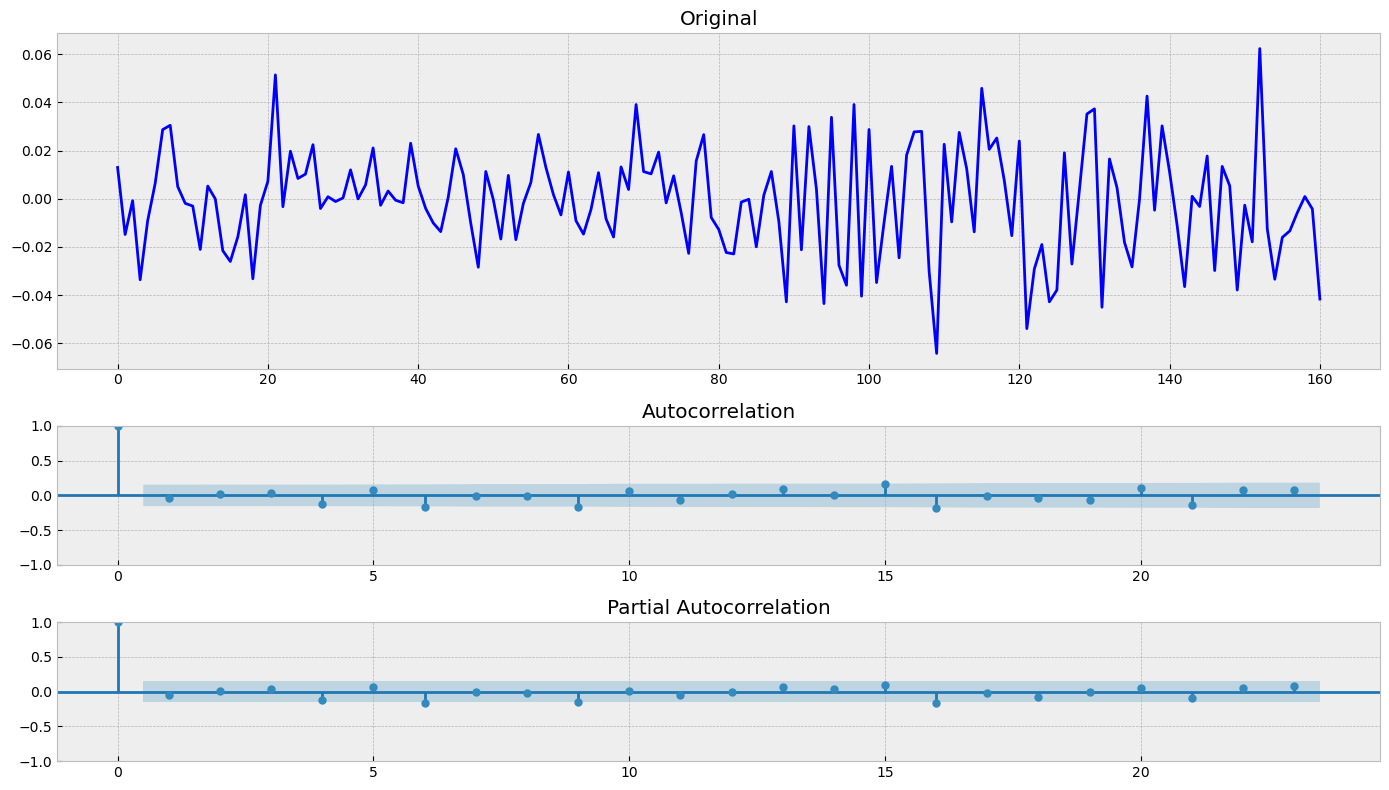

In [34]:
tsplot(series_4)

> Нам помогло и тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!

> Таким образом мы провели анализ 6 времянных рядов и во всех случаях нам удалось <br>
> отвергнуть гипотизу о нестационарности рядов, для каждого из ряда разными методами.